In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Soft_Com/Assignment_3/Dataset_2.csv',encoding='latin1')
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,polarity
9624,Alan's WoW guild said hi to me whilst preparin...,0
4525,i think im slowly going into depression <Emoji...,1
2574,"@raucus Aye at Shepherds Bush, VIP tks aswell...",0
8426,"&quot;You Are My Best Friend&quot; - of Queen,...",0
448,is watching pokÃ¯Â¿Â½mon battle dimensions,0
9905,"@lapetropoulos Thanks for the #followart, LeeA...",0
5332,I have a sleep-deprived EEG in the morning tom...,0
6546,@fox_in_space just a little ribbing. If engin...,0
8684,finally startin to feel like i am getting to t...,0
8513,This is a new one on Twitter: @justinlevy (gre...,0


In [4]:
df.groupby('polarity').size()

polarity
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'text')

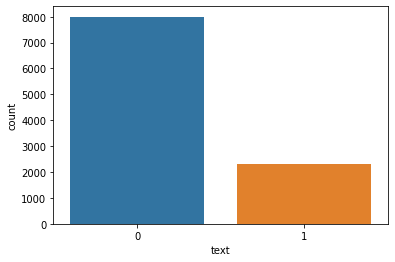

In [5]:

sns.countplot(df.polarity)
plt.xlabel('text')

In [6]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [7]:
batch_size = 100

In [8]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
len(dataset.token2idx)

22212

In [10]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 3
learning_rate = 0.01
sequence_length = 1
num_epochs = 30

In [11]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh',bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [14]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 10 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model : {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/30], Step [10/83], Loss: 0.6164
Epoch [1/30], Step [20/83], Loss: 0.5977
Epoch [1/30], Step [30/83], Loss: 0.5060
Epoch [1/30], Step [40/83], Loss: 0.4723
Epoch [1/30], Step [50/83], Loss: 0.4865
Epoch [1/30], Step [60/83], Loss: 0.4909
Epoch [1/30], Step [70/83], Loss: 0.4910
Epoch [1/30], Step [80/83], Loss: 0.4671
Epoch [2/30], Step [10/83], Loss: 0.4735
Epoch [2/30], Step [20/83], Loss: 0.5072
Epoch [2/30], Step [30/83], Loss: 0.3809
Epoch [2/30], Step [40/83], Loss: 0.3691
Epoch [2/30], Step [50/83], Loss: 0.4036
Epoch [2/30], Step [60/83], Loss: 0.4110
Epoch [2/30], Step [70/83], Loss: 0.4117
Epoch [2/30], Step [80/83], Loss: 0.3778
Epoch [3/30], Step [10/83], Loss: 0.3890
Epoch [3/30], Step [20/83], Loss: 0.3998
Epoch [3/30], Step [30/83], Loss: 0.2937
Epoch [3/30], Step [40/83], Loss: 0.2796
Epoch [3/30], Step [50/83], Loss: 0.3033
Epoch [3/30], Step [60/83], Loss: 0.2978
Epoch [3/30], Step [70/83], Loss: 0.2993
Epoch [3/30], Step [80/83], Loss: 0.2582
Epoch [4/30], St

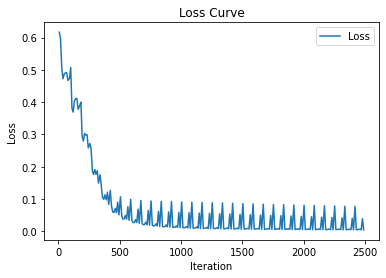

In [17]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

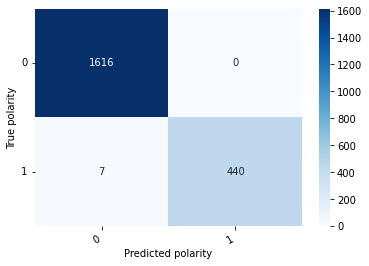

In [18]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [19]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1616.)   tensor(7.)   tensor(0.)   tensor(440.)


In [20]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [21]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  1.0 Recall:  0.9843400716781616 F1_score:  0.9921082258224487


In [22]:
def table(l1, columns):
  plt.rcParams["figure.figsize"] = [10, 2]
  plt.rcParams["figure.autolayout"] = True
  
  fig, axs = plt.subplots(1, 1)
  data = np.column_stack(l1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=columns, loc='center', cellLoc = 'center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(18)
  the_table.scale(1.5, 1.5)
  plt.show()